In [1]:
# https://medium.com/nlplanet/building-a-knowledge-base-from-texts-a-full-practical-example-8dbbffb912fa

In [1]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
import math
import torch

/home/ajayago/anaconda3/envs/huggingface/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from pyvis.network import Network

In [44]:
# Load model and tokenizer
tokenizer = AutoTokenizer.from_pretrained("Babelscape/rebel-large")
model = AutoModelForSeq2SeqLM.from_pretrained("Babelscape/rebel-large")

In [4]:
def extract_relations_from_model_output(text):
    relations = []
    relation, subject, relation, object_ = '', '', '', ''
    text = text.strip()
    current = 'x'
    text_replaced = text.replace("<s>", "").replace("<pad>", "").replace("</s>", "")
    for token in text_replaced.split():
        if token == "<triplet>":
            current = 't'
            if relation != '':
                relations.append({
                    'head': subject.strip(),
                    'type': relation.strip(),
                    'tail': object_.strip()
                })
                relation = ''
            subject = ''
        elif token == "<subj>":
            current = 's'
            if relation != '':
                relations.append({
                    'head': subject.strip(),
                    'type': relation.strip(),
                    'tail': object_.strip()
                })
            object_ = ''
        elif token == "<obj>":
            current = 'o'
            relation = ''
        else:
            if current == 't':
                subject += ' ' + token
            elif current == 's':
                object_ += ' ' + token
            elif current == 'o':
                relation += ' ' + token
    if subject != '' and relation != '' and object_ != '':
        relations.append({
            'head': subject.strip(),
            'type': relation.strip(),
            'tail': object_.strip()
        })
    return relations

In [5]:
class KB():
    def __init__(self):
        self.relations = []

    def are_relations_equal(self, r1, r2):
        return all(r1[attr] == r2[attr] for attr in ["head", "type", "tail"])

    def exists_relation(self, r1):
        return any(self.are_relations_equal(r1, r2) for r2 in self.relations)

    def print(self):
        print("Relations:")
        for r in self.relations:
            print(f"  {r}")
    def merge_relations(self, r1):
        r2 = [r for r in self.relations
              if self.are_relations_equal(r1, r)][0]
        spans_to_add = [span for span in r1["meta"]["spans"]
                        if span not in r2["meta"]["spans"]]
        r2["meta"]["spans"] += spans_to_add

    def add_relation(self, r):
        if not self.exists_relation(r):
            self.relations.append(r)
        else:
            self.merge_relations(r)

In [6]:
def from_small_text_to_kb(text, verbose=False):
    kb = KB()

    # Tokenizer text
    model_inputs = tokenizer(text, max_length=512, padding=True, truncation=True,
                            return_tensors='pt')
    if verbose:
        print(f"Num tokens: {len(model_inputs['input_ids'][0])}")

    # Generate
    gen_kwargs = {
        "max_length": 216,
        "length_penalty": 0,
        "num_beams": 3,
        "num_return_sequences": 3
    }
    generated_tokens = model.generate(
        **model_inputs,
        **gen_kwargs,
    )
    decoded_preds = tokenizer.batch_decode(generated_tokens, skip_special_tokens=False)

    # create kb
    for sentence_pred in decoded_preds:
        relations = extract_relations_from_model_output(sentence_pred)
        for r in relations:
            kb.add_relation(r)

    return kb

In [53]:
def from_text_to_kb(text, span_length=128, verbose=False):
    # tokenize whole text
    inputs = tokenizer([text], return_tensors="pt")

    # compute span boundaries
    num_tokens = len(inputs["input_ids"][0])
    if verbose:
        print(f"Input has {num_tokens} tokens")
    num_spans = math.ceil(num_tokens / span_length)
    if verbose:
        print(f"Input has {num_spans} spans")
    overlap = math.ceil((num_spans * span_length - num_tokens) / 
                        max(num_spans - 1, 1))
    spans_boundaries = []
    start = 0
    for i in range(num_spans):
        spans_boundaries.append([start + span_length * i,
                                 start + span_length * (i + 1)])
        start -= overlap
    if verbose:
        print(f"Span boundaries are {spans_boundaries}")

    # transform input with spans
    tensor_ids = [inputs["input_ids"][0][boundary[0]:boundary[1]]
                  for boundary in spans_boundaries]
    tensor_masks = [inputs["attention_mask"][0][boundary[0]:boundary[1]]
                    for boundary in spans_boundaries]
    inputs = {
        "input_ids": torch.stack(tensor_ids),
        "attention_mask": torch.stack(tensor_masks)
    }

    # generate relations
    num_return_sequences = 3
    gen_kwargs = {
        "max_length": 256,
        "length_penalty": 0,
        "num_beams": 3,
        "num_return_sequences": num_return_sequences
    }
    generated_tokens = model.generate(
        **inputs,
        **gen_kwargs,
    )

    # decode relations
    decoded_preds = tokenizer.batch_decode(generated_tokens,
                                           skip_special_tokens=False)

    print(decoded_preds)

    # create kb
    kb = KB()
    i = 0
    for sentence_pred in decoded_preds:
        current_span_index = i // num_return_sequences
        relations = extract_relations_from_model_output(sentence_pred)
        for relation in relations:
            relation["meta"] = {
                "spans": [spans_boundaries[current_span_index]]
            }
            kb.add_relation(relation)
        i += 1

    return kb

In [32]:
text = """
Napoleon Bonaparte (born Napoleone di Buonaparte; 15 August 1769 – 5 May 1821), and later known by his regnal name Napoleon I, was a French military and political leader who rose to prominence during the French Revolution and led several successful campaigns during the Revolutionary Wars. He was the de facto leader of the French Republic as First Consul from 1799 to 1804. As Napoleon I, he was Emperor of the French from 1804 until 1814 and again in 1815. Napoleon's political and cultural legacy has endured, and he has been one of the most celebrated and controversial leaders in world history. Napoleon was born on the island of Corsica not long after its annexation by the Kingdom of France.[5] He supported the French Revolution in 1789 while serving in the French army, and tried to spread its ideals to his native Corsica. He rose rapidly in the Army after he saved the governing French Directory by firing on royalist insurgents. In 1796, he began a military campaign against the Austrians and their Italian allies, scoring decisive victories and becoming a national hero. Two years later, he led a military expedition to Egypt that served as a springboard to political power. He engineered a coup in November 1799 and became First Consul of the Republic. Differences with the British meant that the French faced the War of the Third Coalition by 1805. Napoleon shattered this coalition with victories in the Ulm Campaign, and at the Battle of Austerlitz, which led to the dissolving of the Holy Roman Empire. In 1806, the Fourth Coalition took up arms against him because Prussia became worried about growing French influence on the continent. Napoleon knocked out Prussia at the battles of Jena and Auerstedt, marched the Grande Armée into Eastern Europe, annihilating the Russians in June 1807 at Friedland, and forcing the defeated nations of the Fourth Coalition to accept the Treaties of Tilsit. Two years later, the Austrians challenged the French again during the War of the Fifth Coalition, but Napoleon solidified his grip over Europe after triumphing at the Battle of Wagram. Hoping to extend the Continental System, his embargo against Britain, Napoleon invaded the Iberian Peninsula and declared his brother Joseph King of Spain in 1808. The Spanish and the Portuguese revolted in the Peninsular War, culminating in defeat for Napoleon's marshals. Napoleon launched an invasion of Russia in the summer of 1812. The resulting campaign witnessed the catastrophic retreat of Napoleon's Grande Armée. In 1813, Prussia and Austria joined Russian forces in a Sixth Coalition against France. A chaotic military campaign resulted in a large coalition army defeating Napoleon at the Battle of Leipzig in October 1813. The coalition invaded France and captured Paris, forcing Napoleon to abdicate in April 1814. He was exiled to the island of Elba, between Corsica and Italy. In France, the Bourbons were restored to power. However, Napoleon escaped Elba in February 1815 and took control of France.[6][7] The Allies responded by forming a Seventh Coalition, which defeated Napoleon at the Battle of Waterloo in June 1815. The British exiled him to the remote island of Saint Helena in the Atlantic, where he died in 1821 at the age of 51. Napoleon had an extensive impact on the modern world, bringing liberal reforms to the many countries he conquered, especially the Low Countries, Switzerland, and parts of modern Italy and Germany. He implemented liberal policies in France and Western Europe.
"""

kb = from_text_to_kb(text, verbose=True)
kb.print()

Input has 726 tokens
Input has 6 spans
Span boundaries are [[0, 128], [119, 247], [238, 366], [357, 485], [476, 604], [595, 723]]
Relations:
  {'head': 'Napoleon Bonaparte', 'type': 'date of birth', 'tail': '15 August 1769', 'meta': {'spans': [[0, 128]]}}
  {'head': 'Napoleon Bonaparte', 'type': 'date of death', 'tail': '5 May 1821', 'meta': {'spans': [[0, 128]]}}
  {'head': 'Napoleon Bonaparte', 'type': 'participant in', 'tail': 'French Revolution', 'meta': {'spans': [[0, 128]]}}
  {'head': 'Napoleon Bonaparte', 'type': 'conflict', 'tail': 'Revolutionary Wars', 'meta': {'spans': [[0, 128]]}}
  {'head': 'Revolutionary Wars', 'type': 'part of', 'tail': 'French Revolution', 'meta': {'spans': [[0, 128]]}}
  {'head': 'French Revolution', 'type': 'participant', 'tail': 'Napoleon Bonaparte', 'meta': {'spans': [[0, 128]]}}
  {'head': 'Revolutionary Wars', 'type': 'participant', 'tail': 'Napoleon Bonaparte', 'meta': {'spans': [[0, 128]]}}
  {'head': 'French Revolution', 'type': 'country', 'tai

In [46]:
text = """
Let's think step by step like a medical expert. First, what is the periodontal ligament? It's a group of fibers that attach the tooth to the bone. Next, what is a heavy force? A force that is greater than the average force. Now, what would happen to the periodontal ligament if there was a heavy force applied to it? The fibers would be stretched or torn. Lastly, what are the consequences of the fibers being stretched or torn? This would cause inflammation and pain.
"""

kb = from_text_to_kb(text, verbose=True)
kb.print()

Input has 109 tokens
Input has 1 spans
Span boundaries are [[0, 128]]
Relations:
  {'head': 'pain', 'type': 'has cause', 'tail': 'inflammation', 'meta': {'spans': [[0, 128]]}}
  {'head': 'inflammation', 'type': 'has effect', 'tail': 'pain', 'meta': {'spans': [[0, 128]]}}
  {'head': 'periodontal ligament', 'type': 'subclass of', 'tail': 'fibers', 'meta': {'spans': [[0, 128]]}}


In [48]:
text = """
Let's derive the differential diagnosis step by step: 1. Heavy forces on periodontal ligament causes: A) Hyalinization The hyalinization of the periodontal ligament is a process that occurs in response to heavy forces on the ligament. This results in the deposition of collagen and other proteins in the ligament, which leads to the formation of a tough, fibrous tissue. This tissue is less able to absorb forces, and as a result, the tooth becomes less stable. B) Osteoclastic activity around tooth Osteoclastic activity is a process that occurs in response to heavy forces on the bone. This results in the resorption of bone tissue, which leads to the formation of a cavity around the tooth. This cavity can weaken the tooth and make it more susceptible to fracture. C) Osteoblastic activity around tooth Osteoblastic activity is a process that occurs in response to heavy forces on the bone. This results in the formation of new bone tissue, which can help to stabilize the tooth. D) Crest bone resorption Crest bone resorption is a process that occurs in response to heavy forces on the bone. This results in the resorption of bone tissue at the crest of the tooth, which can lead to the tooth becoming less stable.
"""

from_text_to_kb(text, verbose=True).print()

Input has 269 tokens
Input has 3 spans
Span boundaries are [[0, 128], [70, 198], [140, 268]]
Relations:
  {'head': 'collagen', 'type': 'subclass of', 'tail': 'protein', 'meta': {'spans': [[0, 128]]}}
  {'head': 'collagen', 'type': 'subclass of', 'tail': 'proteins', 'meta': {'spans': [[0, 128]]}}
  {'head': 'collagen', 'type': 'instance of', 'tail': 'protein', 'meta': {'spans': [[0, 128]]}}
  {'head': 'fracture', 'type': 'has cause', 'tail': 'Osteoclastic activity', 'meta': {'spans': [[70, 198]]}}
  {'head': 'fracture', 'type': 'has cause', 'tail': 'Osteoclastic activity around tooth', 'meta': {'spans': [[70, 198]]}}
  {'head': 'Crest bone resorption', 'type': 'subclass of', 'tail': 'resorption', 'meta': {'spans': [[140, 268]]}}
  {'head': 'fracture', 'type': 'has cause', 'tail': 'Osteoblastic activity', 'meta': {'spans': [[140, 268]]}}
  {'head': 'Crest bone resorption', 'type': 'instance of', 'tail': 'resorption', 'meta': {'spans': [[140, 268]]}}


In [55]:
text = """
"Let's think step by step like a medical expert. \n\nThe first thing the resident should do is to tell the attending that he cannot fail to disclose this mistake. This is the most important thing to do in order to protect the patient's safety. \n\nThe second thing the resident should do is to report the physician to the ethics committee. This is the best way to make sure that the attending does not make this mistake again in the future."
"""
from_text_to_kb(text, verbose=True).print()

Input has 98 tokens
Input has 1 spans
Span boundaries are [[0, 128]]
['<s><triplet> physician <subj> medical <obj> field of this occupation <triplet> medical <subj> physician <obj> practiced by</s>', '<s><triplet> physician <subj> medical <obj> field of this occupation</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>', '<s><triplet> neurosurgeon <subj> medical <obj> subclass of</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>']
Relations:
  {'head': 'physician', 'type': 'field of this occupation', 'tail': 'medical', 'meta': {'spans': [[0, 128]]}}
  {'head': 'medical', 'type': 'practiced by', 'tail': 'physician', 'meta': {'spans': [[0, 128]]}}
  {'head': 'neurosurgeon', 'type': 'subclass of', 'tail': 'medical', 'meta': {'spans': [[0, 128]]}}


### NER

## NER

In [18]:
from transformers import pipeline

# create pipeline for NER
ner = pipeline('ner', aggregation_strategy = 'simple')

No model was supplied, defaulted to dbmdz/bert-large-cased-finetuned-conll03-english and revision f2482bf (https://huggingface.co/dbmdz/bert-large-cased-finetuned-conll03-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
config.json: 100%|██████████| 998/998 [00:00<00:00, 70.2kB/s]
model.safetensors: 100%|██████████| 1.33G/1.33G [00:12<00:00, 104MB/s] 
Some weights of the model checkpoint at dbmdz/bert-large-cased-finetuned-conll03-english were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly ident

In [43]:
ner("Let's use step by step inductive reasoning, given the medical nature of the question. First, the study found that there was a 53% prevalence of self-reported problems with sleep and energy. This suggests that there is a significant portion of the population that is affected by sleep disorders. Second, the study found that without correction of cut-point shifts, age, sex, and the number of comorbidities were significantly associated with a greater severity of sleep-related problems. This suggests that these factors may be contributing to the severity of sleep disorders. Third, the study found that after correction, age, the number of comorbidities, and regular exercise were significantly associated with a greater severity of sleep-related problems; sex was no longer a significant factor. This suggests that adjustment for reporting heterogeneity may be necessary in order to accurately identify the factors associated with sleep disorders. Therefore, it is most likely that adjustment for reporting heterogeneity is necessary in sleep disorders.")

[]

In [42]:
# not good!!!
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForTokenClassification

tokenizer = AutoTokenizer.from_pretrained("d4data/biomedical-ner-all")
model = AutoModelForTokenClassification.from_pretrained("d4data/biomedical-ner-all")

pipe = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="simple") # pass device=0 if using gpu
pipe("""Let's use step by step inductive reasoning, given the medical nature of the question. First, the study found that there was a 53% prevalence of self-reported problems with sleep and energy. This suggests that there is a significant portion of the population that is affected by sleep disorders. Second, the study found that without correction of cut-point shifts, age, sex, and the number of comorbidities were significantly associated with a greater severity of sleep-related problems. This suggests that these factors may be contributing to the severity of sleep disorders. Third, the study found that after correction, age, the number of comorbidities, and regular exercise were significantly associated with a greater severity of sleep-related problems; sex was no longer a significant factor. This suggests that adjustment for reporting heterogeneity may be necessary in order to accurately identify the factors associated with sleep disorders. Therefore, it is most likely that adjustment for reporting heterogeneity is necessary in sleep disorders.""")


[{'entity_group': 'Lab_value',
  'score': 0.78727543,
  'word': '%',
  'start': 128,
  'end': 129},
 {'entity_group': 'Activity',
  'score': 0.49062246,
  'word': 'regular',
  'start': 660,
  'end': 667},
 {'entity_group': 'Activity',
  'score': 0.6642873,
  'word': 'exercise',
  'start': 668,
  'end': 676},
 {'entity_group': 'Disease_disorder',
  'score': 0.36377394,
  'word': 'sex',
  'start': 758,
  'end': 761},
 {'entity_group': 'Coreference',
  'score': 0.9036154,
  'word': 'het',
  'start': 842,
  'end': 845},
 {'entity_group': 'Coreference',
  'score': 0.46483764,
  'word': '##y',
  'start': 854,
  'end': 855},
 {'entity_group': 'Coreference',
  'score': 0.92608947,
  'word': 'het',
  'start': 1009,
  'end': 1012},
 {'entity_group': 'Coreference',
  'score': 0.561567,
  'word': '##y',
  'start': 1021,
  'end': 1022}]

In [56]:
# Sentence BERT to create embeddings for the sentences
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("all-MiniLM-L6-v2")

config_sentence_transformers.json: 100%|██████████| 116/116 [00:00<00:00, 34.5kB/s]
README.md: 100%|██████████| 10.7k/10.7k [00:00<00:00, 2.33MB/s]
sentence_bert_config.json: 100%|██████████| 53.0/53.0 [00:00<00:00, 15.2kB/s]
config.json: 100%|██████████| 612/612 [00:00<00:00, 182kB/s]
pytorch_model.bin: 100%|██████████| 90.9M/90.9M [00:01<00:00, 84.6MB/s]
tokenizer_config.json: 100%|██████████| 350/350 [00:00<00:00, 104kB/s]
vocab.txt: 100%|██████████| 232k/232k [00:00<00:00, 22.1MB/s]
tokenizer.json: 100%|██████████| 466k/466k [00:00<00:00, 1.88MB/s]
1_Pooling/config.json: 100%|██████████| 190/190 [00:00<00:00, 11.8kB/s]
/home/ajayago/anaconda3/envs/huggingface/lib/python3.8/site-packages/torch/cuda/__init__.py:141: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org

In [60]:
sentences = [
    "Let's derive the differential diagnosis step by step: 1. Heavy forces on periodontal ligament causes: A) Hyalinization The hyalinization of the periodontal ligament is a process that occurs in response to heavy forces on the ligament. This results in the deposition of collagen and other proteins in the ligament, which leads to the formation of a tough, fibrous tissue. This tissue is less able to absorb forces, and as a result, the tooth becomes less stable. B) Osteoclastic activity around tooth Osteoclastic activity is a process that occurs in response to heavy forces on the bone. This results in the resorption of bone tissue, which leads to the formation of a cavity around the tooth. This cavity can weaken the tooth and make it more susceptible to fracture. C) Osteoblastic activity around tooth Osteoblastic activity is a process that occurs in response to heavy forces on the bone. This results in the formation of new bone tissue, which can help to stabilize the tooth. D) Crest bone resorption Crest bone resorption is a process that occurs in response to heavy forces on the bone. This results in the resorption of bone tissue at the crest of the tooth, which can lead to the tooth becoming less stable.",
]
sentence_embeddings = model.encode(sentences)

In [61]:
sentence_embeddings.shape

(1, 384)

In [63]:
# Actual CoT in Med_MC_QA and generated CoT (from ThoughtSource)
sentences = [
    "Answer- A. Glycogen synthesisLow insulin to glucagon ratio implies a catabolic state, i.e. usage of body stores to form energy, typically seen in fasting state ancl diabetes mellitus. Hence, this state will promote glycogen breakdown, gluconeogenesis as well as ketone body formation, while at the same time inhibiting glycogen synthesis and storage.",
    "Let's think step by step like a medical expert. \n\nFirst, we know that the low insulin to glucagon ratio is seen in diabetes. So, we can eliminate A and B because glycogen synthesis and glycogen breakdown are regulated by insulin.\n\nNext, we know that gluconeogenesis is the process of making glucose from non-carbohydrate sources. So, we can eliminate D because ketogenesis is the process of making ketone bodies from fatty acids. \n\nTherefore, the answer is C) Gluconeogenesis."
]
sentence_embeddings = model.encode(sentences)

In [64]:
sentence_embeddings.shape

(2, 384)

In [67]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity(sentence_embeddings[[0]], sentence_embeddings[[1]])

array([[0.6474214]], dtype=float32)

In [74]:
# For each step convert to embeddings
# For gpt-3.5-turbo-0613 from https://chat.lmsys.org/
question = """
1. <step1>
2. <step2>
...
So the answer is (<answer>).
Make sure that the answer uses the above format. Answer the question step by step.

Question: Low insulin to glucagon ratio is seen in all of these except:
A) Glycogen synthesis
B) Glycogen breakdown
C) Gluconeogenesis
D) Ketogenesis
1. Low insulin to glucagon ratio implies a catabolic state, i.e. usage of body stores to form energy, typically seen in fasting state ancl diabetes mellitus.
2. Catabolic state promotes glycogen breakdown, gluconeogenesis and ketogenesis.
3. Glycogen synthesis is an anabolic process, which is promoted by insulin.
So the answer is A.

Question: Axonal transport is:
A) Antegrade
B) Retrograde
C) Antegrade and retrograde
D) None
"""
result = """1. Axonal transport refers to the movement of materials along the axon of a neuron.
2. Antegrade axonal transport refers to the movement of materials from the cell body towards the axon terminal.
3. Retrograde axonal transport refers to the movement of materials from the axon terminal towards the cell body.
4. Antegrade and retrograde axonal transport are two directions of transport that occur simultaneously in neurons.
So the answer is C."""

result_emb = model.encode(result.split("\n")[:-1])
    

In [73]:
result_emb.shape

(4, 384)

In [75]:
# graph extraction
graph_query = """
Convert each of the following sentences into (subject, predicate, object) form. Predicates can be "administered to", "affects", "associated with", "augments", "causes", "coexists with", "converts to", "complicates", "diagnoses",  "disrupts", "inhibits", "interacts with", "is a", "location of", "manifestation of", "method of", "occurs in", "part of", "precedes", "predisposes", "prevents", "process of", "produces", "stimulates", "treats", "uses", "compared with","higher than", "lower than", "same as".
Example:  Given: Axonal transport refers to the movement of materials along the axon of a neuron.
Answer: (axonal transport, process of, movement of materials along the axon of a neuron)
Given: Antegrade axonal transport refers to the movement of materials from the cell body towards the axon terminal.
Answer: (Antegrade axonal transport , process of, movement of materials from the cell body towards the axon terminal)
Given: Retrograde axonal transport refers to the movement of materials from the axon terminal towards the cell body.
Given: Antegrade and retrograde axonal transport are two directions of transport that occur simultaneously in neurons.
"""
graph_generated = """
Given: Retrograde axonal transport refers to the movement of materials from the axon terminal towards the cell body.
Answer: (Retrograde axonal transport, process of, movement of materials from the axon terminal towards the cell body)

Given: Antegrade and retrograde axonal transport are two directions of transport that occur simultaneously in neurons.
Answer: (Antegrade and retrograde axonal transport, coexist and occur simultaneously, two directions of transport)
"""
    

In [76]:
import pandas as pd
semmed_db = pd.read_csv("/data/ajayago/KB_embeddings/dataset/polypharmacy/PREDICATIONS_OCCURS.csv")
semmed_db.head()

,PREDICATE,SUBJECT_CUI,SUBJECT_NAME,SUBJECT_SEMTYPE,SUBJECT_NOVELTY,SUBJECT_SCORE,OBJECT_CUI,OBJECT_NAME,OBJECT_SEMTYPE,OBJECT_NOVELTY,OBJECT_SCORE,OCCURS
0,ADMINISTERED_TO,C0000248,2-Acetylaminofluorene,hops,1.0,1000,C0018561,Mesocricetus auratus,mamm,1.0,1000,2
1,ADMINISTERED_TO,C0000248,2-Acetylaminofluorene,hops,1.0,1000,C0034693,Rattus norvegicus,mamm,1.0,861,31
2,ADMINISTERED_TO,C0000248,2-Acetylaminofluorene,hops,1.0,1000,C0034693,Rattus norvegicus,mamm,1.0,1000,31
3,ADMINISTERED_TO,C0000275,2-Chloroadenosine,phsu,1.0,1000,C0034693,Rattus norvegicus,mamm,1.0,1000,2
4,ADMINISTERED_TO,C0000407,3-Hydroxyanthranilic Acid,bacs,1.0,1000,C0029974,Ovum,cell,1.0,888,1


In [120]:
semmed_db[semmed_db["OBJECT_NAME"].str.contains("antegrade")]

,PREDICATE,SUBJECT_CUI,SUBJECT_NAME,SUBJECT_SEMTYPE,SUBJECT_NOVELTY,SUBJECT_SCORE,OBJECT_CUI,OBJECT_NAME,OBJECT_SEMTYPE,OBJECT_NOVELTY,OBJECT_SCORE,OCCURS


In [82]:
import networkx as nx

In [83]:
# load Semmed DB into memory
G = nx.from_pandas_edgelist(semmed_db, source="SUBJECT_NAME", target="OBJECT_NAME", edge_attr="OCCURS", edge_key="PREDICATE")

In [96]:
nx.number_of_nodes(G)

296623

In [97]:
nx.number_of_edges(G)

14087608

In [100]:
for i in nx.neighbors(G, "fast axonal transport"):
    print(i)

Nerve Regeneration
Axoplasmic Flow
Deuterium Oxide
Antimitotic Agents
Microtubules
Ca(2+)-Transporting ATPase|DNAH8
Dimethyl Sulfoxide
Actins
Rattus norvegicus
Oryctolagus cuniculus
Lipids
Ions
6-Aminonicotinamide
Batrachotoxins
Tetrodotoxin
cooling
Ouabain
Amitriptyline
Calcium
Chlorprothixene
Clomipramine
Desipramine
Haloperidol
Imipramine
Penfluridol
Peripheral Neuropathy
Pyruvate
Recovery
Amides
Dibenzazepines
Proteins
Aplysia
Endopeptidases
Degenerative abnormality
Chromosome Pairing
Intercellular Communication
Membrane Potentials
Physiologic Function
Carbon Dioxide
Cobalt
Cell physiology
Loligo pealei
ATP phosphohydrolase|DNAH8
Gossypol
Therapeutic procedure
POMC gene|POMC
Tetracaine
Estramustine phosphate
Chlorpromazine
Lofepramine
Thioridazine
Trifluoperazine
Hypertrophy
Deoxyribonuclease I|DNASE1
Lidocaine
Procaine
Adenine
Lobster
Ethanol
Motility
Local Anesthetics
Antibodies
Bupivacaine
Mepivacaine
Prilocaine
Gelsolin|GSN
Coated vesicle
Cytoskeletal Proteins
Cycloheximide
Syn

In [84]:
cot = nx.DiGraph()
cot.add_edges_from([("axonal transport", "movement of materials along the axon of a neuron"),
                    ("antegrade axonal transport", "movement of materials from the cell body towards the axon terminal"),
                    ("retrograde axonal transport", "movement of materials from the axon terminal towards the cell body"),
                    ("antegrade and retrograde axonal transport", "two directions of transport")
                   ])

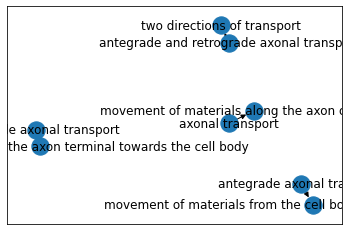

In [90]:
import matplotlib.pyplot as plt
nx.draw_networkx(cot)

In [91]:
# check all possible isomorphism between subgraph and graph
for i in nx.vf2pp_all_isomorphisms(G, cot, node_label=None, default_label=None):
    print(i)

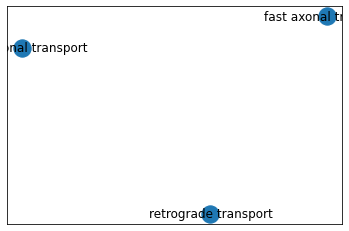

In [121]:
subG = G.subgraph(["fast axonal transport", "retrograde transport", "slow axonal transport"])
nx.draw_networkx(subG, arrows=True,)

In [122]:
list(subG.edges)

[]

In [113]:
for i in nx.all_shortest_paths(G, source="slow axonal transport", target="retrograde transport"):
    print(i)

['slow axonal transport', 'Nerve Regeneration', 'retrograde transport']
['slow axonal transport', 'Neurons', 'retrograde transport']
['slow axonal transport', 'Injury', 'retrograde transport']
['slow axonal transport', 'Mus', 'retrograde transport']
['slow axonal transport', 'Rattus norvegicus', 'retrograde transport']
['slow axonal transport', 'Physiologic Organization', 'retrograde transport']
['slow axonal transport', 'Pathogenesis', 'retrograde transport']
['slow axonal transport', 'Oryctolagus cuniculus', 'retrograde transport']
['slow axonal transport', 'Animalia', 'retrograde transport']
['slow axonal transport', 'Animals', 'retrograde transport']
['slow axonal transport', 'Intraocular pressure disorder', 'retrograde transport']
['slow axonal transport', 'Neural Development', 'retrograde transport']
['slow axonal transport', 'axonal guidance', 'retrograde transport']
['slow axonal transport', 'Cytoplasmic dynein', 'retrograde transport']
['slow axonal transport', 'Motor protein'

In [123]:
for i in nx.all_shortest_paths(G, source="fast axonal transport", target="retrograde transport"):
    print(i)

['fast axonal transport', 'Nerve Regeneration', 'retrograde transport']
['fast axonal transport', 'Microtubules', 'retrograde transport']
['fast axonal transport', 'Actins', 'retrograde transport']
['fast axonal transport', 'Rattus norvegicus', 'retrograde transport']
['fast axonal transport', 'Oryctolagus cuniculus', 'retrograde transport']
['fast axonal transport', 'Tetrodotoxin', 'retrograde transport']
['fast axonal transport', 'Calcium', 'retrograde transport']
['fast axonal transport', 'Clomipramine', 'retrograde transport']
['fast axonal transport', 'Haloperidol', 'retrograde transport']
['fast axonal transport', 'Proteins', 'retrograde transport']
['fast axonal transport', 'Endopeptidases', 'retrograde transport']
['fast axonal transport', 'Degenerative abnormality', 'retrograde transport']
['fast axonal transport', 'Cell physiology', 'retrograde transport']
['fast axonal transport', 'Therapeutic procedure', 'retrograde transport']
['fast axonal transport', 'Chlorpromazine', 'r